C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


(0, 'The solver successfully reached the end of the integration interval.') 3650.0
--- 0.6520171165466309 seconds ---


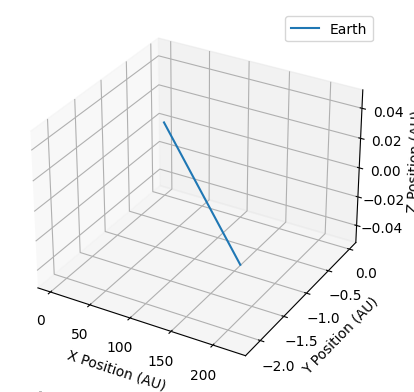

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from numba import jit

class body:
    def __init__(self, location, mass, velocity, name=""):
        self.location = np.array(location, dtype=np.float64) 
        self.mass = mass
        self.velocity = np.array(velocity, dtype=np.float64)
        self.name = name

@jit(nopython=True)
def n_body_equations(t, y, masses):
    n = len(masses)
    positions = y[:3*n].reshape((n, 3))
    velocities = y[3*n:].reshape((n, 3))
    accelerations = np.zeros((n, 3))

    for i in range(n):
        for j in range(i+1, n):  # Calculate each interaction only once
            r_vector = positions[j] - positions[i]
            r = np.sqrt(np.sum(r_vector**2))  # Manually compute the Euclidean norm
            force = G_const * masses[i] * masses[j] / r**3

            # Update the acceleration of both bodies
            accelerations[i] += force * r_vector
            accelerations[j] -= force * r_vector

    return np.concatenate((velocities.ravel(), accelerations.ravel()))

# Constants
G_const = 2.993456967277e13  # AU^3 kg^-1 day^-2
AUm = 1.496e11  # meters/AU

# Planet data (location (m), mass (kg), velocity (m/s))
planets = {
    "Sun": body((0, 0, 0), 2e30, (0, 0, 0), "Sun"),
    #"Mercury": body((0, 0.387, 0), 3.285e23, (0.027664, 0, 0), "Mercury"),
    #"Venus": body((0, 0.723, 0), 4.8e24, (0.020214, 0, 0), "Venus"),
    "Earth": body((0, 1.0, 0), 5.972e24, (0.017211, 0, 0), "Earth"),
    #"Mars": body((0, 1.524, 0), 2.4e24, (0.013919, 0, 0), "Mars"),
    #"Jupiter": body((0, 5.2039, 0), 1e28, (0.007566, 0, 0), "Jupiter"),
    #"Saturn": body((0, 9.5723, 0), 5.7e26, (0.005602, 0, 0), "Saturn"),
    #"Uranus": body((0, 19.1647, 0), 8.7e25, (0.003927, 0, 0), "Uranus"),
    #"Neptune": body((0, 30.1809, 0), 1e26, (0.003119, 0, 0), "Neptune"),
    #"Pluto": body((0, 39.4818, 0), 1.3e22, (0.002738, 0, 0), "Pluto")
}   

bodies = [planets[name] for name in planets]

# Prepare initial conditions and masses
initial_positions = np.array([b.location for b in bodies])
initial_velocities = np.array([b.velocity for b in bodies])
initial_conditions = np.concatenate([initial_positions.ravel(), initial_velocities.ravel()])
masses = np.array([b.mass for b in bodies])

# Time span for the simulation
time_span = [0, 3650]  # Days

# Solve the ODE
import time
start_time = time.time()

try:
    solution = solve_ivp(n_body_equations, time_span, initial_conditions, args=(masses,),
                         method='RK45', rtol=100, atol=10, min_step=1e-2, max_step=10)
    status_message = (solution.status, solution.message)
    final_time = solution.t[-1]
except Exception as e:
    error_message = str(e)
    status_message = None
    final_time = None

print(status_message, final_time)
print("--- %s seconds ---" % (time.time() - start_time))
# Post-process the solution for plotting
n = len(bodies)
times = solution.t
positions = solution.y[:3*n].reshape(n, 3, -1)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i, body in enumerate(bodies):
    if body.name == "Earth":
        ax.plot(positions[i, 0], positions[i, 1], positions[i, 2], label=body.name)
ax.set_xlabel('X Position (AU)')
ax.set_ylabel('Y Position (AU)')
ax.set_zlabel('Z Position (AU)')
ax.legend()
plt.show()
